## Inference in non-Gaussian stochastic volatility models

This tutorial demonstrates inference using the Levy [Stable](http://docs.pyro.ai/en/stable/distributions.html#stable) distribution.

In [1]:
import math
import os
import pandas as pd
import torch
import pyro
import pyro.distributions as dist
from matplotlib import pyplot
from torch.distributions import constraints

from pyro import poutine
from pyro.infer import EnergyDistance, SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer.reparam import SymmetricStableReparam
from pyro.optim import ClippedAdam
from pyro.ops.tensor_utils import convolve

%matplotlib inline
%config InlineBackend.rc = {'figure.facecolor': (1, 1, 1, 1)}
%config InlineBackend.figure_formats = ['svg']

In [2]:
df = pd.read_csv(os.path.expanduser("~/Downloads/snp500.csv"))
#df = pd.read_csv(os.path.expanduser("~/Downloads/KO.csv"))

In [3]:
x = torch.tensor(df["Close"]).float()

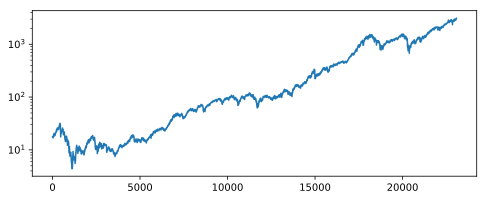

In [4]:
pyplot.figure(figsize=(8, 3))
pyplot.plot(x)
pyplot.yscale('log')

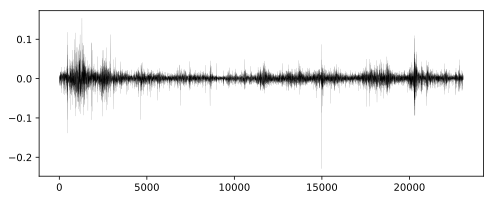

In [5]:
pyplot.figure(figsize=(8, 3))
r = (x[1:] / x[:-1]).log()
pyplot.plot(r, "k", lw=0.1);

mean = 0.00022394036932382733
std = 0.011869287118315697


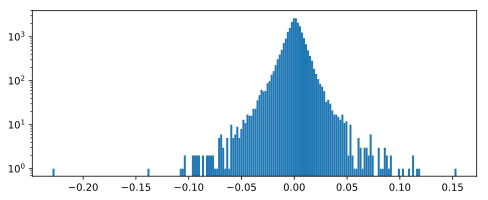

In [6]:
pyplot.figure(figsize=(8, 3))
pyplot.hist(r, bins=200)
pyplot.yscale('log')
print("mean = {}".format(r.mean()))
print("std = {}".format(r.std()))

First let's fit a single distribution to the returns.

In [7]:
def model():
    stability = pyro.param("stability", torch.tensor(1.9),
                           constraint=constraints.interval(0, 2))
    skew = 0.
    scale = pyro.param("scale", torch.tensor(0.1), constraint=constraints.positive)
    loc = pyro.param("loc", torch.tensor(0.))
    with pyro.plate("data", len(r)):
        return pyro.sample("r", dist.Stable(stability, skew, scale, loc), obs=r)

step 0 loss = 8.169078826904297
step 20 loss = 2.480233669281006
step 40 loss = 2.322582960128784
step 60 loss = 1.3298510313034058
step 80 loss = 1.296791434288025
step 100 loss = 1.2887918949127197
step 120 loss = 1.315025806427002
step 140 loss = 1.2715963125228882
step 160 loss = 1.2690484523773193
step 180 loss = 1.2737268209457397
step 200 loss = 1.2896374464035034
loc = 0.00019957474432885647
scale = 0.008347502909600735
stability = 1.979245662689209
CPU times: user 16 s, sys: 672 ms, total: 16.6 s
Wall time: 2.55 s


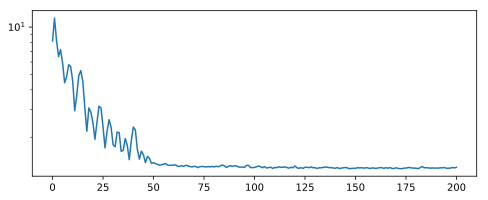

In [8]:
%%time
pyro.clear_param_store()
pyro.set_rng_seed(1234567890)
pyro.enable_validation(True)
num_steps = 201
optim = ClippedAdam({"lr": 0.1, "lrd": 0.1 ** (1 / num_steps)})
svi = SVI(model, lambda: None, optim, EnergyDistance())
losses = []
for step in range(num_steps):
    loss = svi.step()
    losses.append(loss)
    if step % 20 == 0:
        print("step {} loss = {}".format(step, loss))

pyplot.figure(figsize=(8, 3))
pyplot.plot(losses)
pyplot.yscale('log')
for name, value in sorted(pyro.get_param_store().items()):
    if value.numel() == 1:
        print("{} = {}".format(name, value.squeeze().item()))

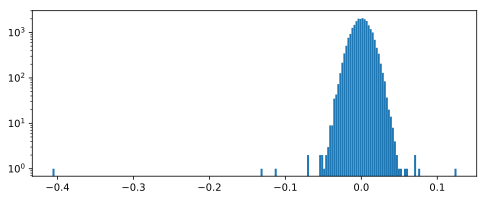

In [9]:
samples = poutine.uncondition(model)().detach()
pyplot.figure(figsize=(8, 3), dpi=300)
pyplot.hist(samples, bins=200)
pyplot.yscale('log')

This is a poor fit, but that's to be expected since we're mixing all time steps together: we would expect this to be a scale-mixture of distributions (Normal, or Stable), but are modeling it as a single distribution (Stable in this case).

## Modeling in Pyro

Consider a stochastic volatity model of the log returns `r_t` and a latent volatility `h`:
$$
  \log h_t = \delta + \phi \log h_{t-1} + \sigma v_t \\
  r_t = w_t \sqrt{h_t}
$$
Usually $\sigma v_1$ and $w_t$ are both Gaussian. We will generalize to a symmetric Stable distributoin for $\sigma v_t$.

In [14]:
def model(data):
    time_plate = pyro.plate("time", len(data))

    # We model volatility as a symmetric Stable process.
    # This is expressed as a factor graph.
    h_stability = pyro.sample("h_stability", dist.Uniform(1.01, 1.99))
    h_scale = pyro.sample("h_scale", dist.LogNormal(0, 3))
    h_loc = pyro.sample("h_loc", dist.Normal(0, 1))
    with time_plate:
        # We manually reparameterize to improve geometry.
        # The distribution here is masked out and is only used for initialization.
        log_h = pyro.sample("log_h", dist.Normal(0, 1e-4).mask(False))
    with pyro.plate("dtime", len(data) - 1):
        pyro.sample("h_noise", dist.Stable(h_stability, 0.),
                    obs=log_h[..., 1:] - log_h[..., :-1])
    log_h = log_h * h_scale + h_loc

    # Observed log returns.
    r_stability = pyro.sample("r_stability", dist.Uniform(1.01, 1.99))
    r_scale = log_h.mul(0.5).exp()
    r_loc = pyro.sample("r_loc", dist.Normal(0, 1e-2))
    with time_plate:
        pyro.sample("r", dist.Stable(r_stability, 0., r_scale, r_loc), obs=data)

step 0 loss = 11.915
step 50 loss = 0.194149
step 100 loss = -1.23448
step 150 loss = -1.31748
step 200 loss = -1.62618
step 250 loss = -1.87661
step 300 loss = -1.5922
step 350 loss = -1.92518
step 400 loss = -1.79547
step 450 loss = -2.17764
step 500 loss = -2.26503
step 550 loss = -1.76502
step 600 loss = -2.43719
step 650 loss = -1.58492
step 700 loss = -2.42905
step 750 loss = -2.59519
step 800 loss = -2.676
step 850 loss = -2.68919
step 900 loss = -2.6756
step 950 loss = -2.71697
step 1000 loss = -2.6427
step 1050 loss = -2.76064
step 1100 loss = -2.72453
step 1150 loss = -2.76803
step 1200 loss = -2.67492
step 1250 loss = -2.78782
step 1300 loss = -2.7671
step 1350 loss = -2.80869
step 1400 loss = -2.81849
step 1450 loss = -2.80581
step 1500 loss = -2.81975
step 1550 loss = -2.81871
step 1600 loss = -2.79648
step 1650 loss = -2.83884
step 1700 loss = -2.83123
step 1750 loss = -2.82952
step 1800 loss = -2.83053
step 1850 loss = -2.82821
step 1900 loss = -2.82896
step 1950 loss = 

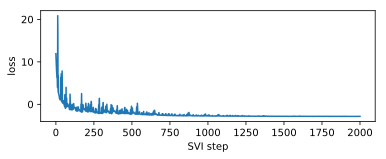

In [15]:
pyro.clear_param_store()
pyro.set_rng_seed(1234567890)
pyro.enable_validation(True)
num_steps = 2001
optim = ClippedAdam({"lr": 0.1,
                     "betas": (0.9, 0.99),
                     "lrd": 0.01 ** (1 / num_steps)})
reparam_model = poutine.reparam(model, {"h_noise": SymmetricStableReparam(),
                                        "r": SymmetricStableReparam()})
guide = AutoDiagonalNormal(reparam_model)
svi = SVI(reparam_model, guide, optim, Trace_ELBO())
losses = []
for step in range(num_steps):
    loss = svi.step(r) / len(r)
    losses.append(loss)
    if step % 50 == 0:
        median = guide.median()
        print("step {} loss = {:0.6g}".format(step, loss))

pyplot.figure(figsize=(6,2))
pyplot.plot(losses)
pyplot.ylabel("loss")
pyplot.xlabel("SVI step")
for name, value in sorted(guide.median().items()):
    if value.numel() == 1:
        print("{} = {}".format(name, value.squeeze().item()))

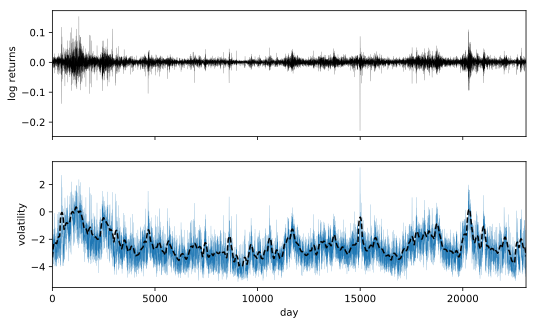

In [16]:
fig, axes = pyplot.subplots(2, figsize=(8.5, 5), sharex=True)
axes[0].plot(r, "k", lw=0.2)
axes[0].set_ylabel("log returns")
axes[0].set_xlim(0, len(r))

log_h = guide.median()["log_h"].detach()
axes[1].plot(log_h, lw=0.2)

window = torch.linspace(0., 1., 200) * torch.linspace(1., 0., 200)
window /= window.sum()
conv_log_h = convolve(log_h.exp(), window, mode="same").log()
axes[1].plot(conv_log_h, 'k--')
axes[1].set_ylabel("volatility")
axes[1].set_xlabel("day");